# Quick Event analysis

Just to check the events and maybe delete some of them we will analyse it a bit

In [1]:
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import numpy as np

from pprint import pprint
from IPython.display import display
from typing import Dict, Union, List, Callable
from pathlib import Path

import lib.util
import lib.data_preparation
import lib.event_detection

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from tqdm.notebook import tqdm
tqdm.pandas()

sns.set_style('darkgrid')
sns.set_context('notebook')

pd.set_option('max_columns', None)

In [2]:
folderpath = Path('data/UAH-DRIVESET-v1/')

In [3]:
df = lib.util.read_parquet_and_prepare(
    filepath=Path(folderpath, 'data_event.parquet'),
    col_reindex=None
)

In [4]:
display(df.head())

,timestamp,time_gps,latitude,longitude,altitude,vertical accuracy,horizontal accuracy,course,difcourse: course variation,position state,lanex dist state,lanex history,path,trip_gps,time_osm,current road maxspeed,maxspeed reliability,road type,# of lanes in road,estimated current lane,latitude used to query osm,longitude used to query osm,delay answer osm query,trip_osm,time,above 50kph,gx,gy,gz,gx_filt,gy_filt,gz_filt,roll,pitch,yaw,trip,speed,yr,beta,vx,vy,curvature,distx,disty,distance,change_points,dtime,corner_flag,straight_flag,corner_event,straight_event
idx,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2015-12-11 16:56:19.910,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.107936,-0.041451,-0.39240,-0.006,-0.009,-0.022,-1.561743,0.011128,0.097137,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.004842,-0.044547,36.632824,-0.028482,433436.793932,0.000000,0.000000,0.000000,False,0.0,False,True,NaN,NaN
1,2015-12-11 16:56:20.010,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.186017,-0.053898,-0.36297,-0.002,-0.006,-0.034,-1.561573,0.013535,0.097621,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.005547,-0.057444,36.632817,-0.036728,378370.393667,3.663279,0.002966,3.663280,False,0.1,False,True,NaN,NaN
2,2015-12-11 16:56:20.110,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.213286,-0.044389,-0.12753,0.011,-0.010,-0.021,-1.560896,0.015397,0.098246,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.006464,-0.048522,36.632822,-0.031023,324710.369281,3.663279,0.002874,3.663280,False,0.1,False,True,NaN,NaN
3,2015-12-11 16:56:20.210,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.229753,0.008214,-0.40221,0.023,-0.002,-0.031,-1.559989,0.016346,0.098914,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.008321,0.002894,36.632835,0.001850,252239.921285,3.663285,0.004844,3.663289,False,0.1,False,True,NaN,NaN
4,2015-12-11 16:56:20.310,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.132273,-0.010419,-0.40221,0.023,-0.002,-0.031,-1.557711,0.017944,0.099910,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.009965,-0.016791,36.632834,-0.010735,210630.254921,3.663275,0.005912,3.663280,False,0.1,False,True,NaN,NaN


In [5]:
df.known_divisions

True

I test how to aggregrate with multilple columns and functions and make a util function for it:

"lib.util.agg_multilple()"

In [6]:
gb_corner = df.groupby('corner_event')
extent = lib.util.dask_agg_extent()
largest = lib.util.dask_agg_largest()

gb_corner_dyn = gb_corner[['speed', 'yr', 'gy', 'gx', 'beta']].agg(
    [largest, extent, 'mean', 'max', 'min']
)
gb_corner_meta = gb_corner[['distance', 'dtime']].sum()

corner = gb_corner_dyn.join(gb_corner_meta)
corner = corner.rename(columns=lambda x: '_'.join(x) if isinstance(x, tuple) else x)
display(corner.head())

,speed_largest,speed_extent,speed_mean,speed_max,speed_min,yr_largest,yr_extent,yr_mean,yr_max,yr_min,gy_largest,gy_extent,gy_mean,gy_max,gy_min,gx_largest,gx_extent,gx_mean,gx_max,gx_min,beta_largest,beta_extent,beta_mean,beta_max,beta_min,distance,dtime
corner_event,,,,,,,,,,,,,,,,,,,,,,,,,,,
12km-D5-AGGRESSIVE-SECONDARY24x21,91.608581,1.193064,91.012049,91.608581,90.415517,-0.080482,0.029090,-0.065430,-0.051393,-0.080482,0.562122,1.031994,0.172275,0.562122,-0.469872,-1.732090,2.839531,-0.223183,1.107441,-1.732090,0.596920,1.041790,0.201147,0.596920,-0.444870,121.366326,4.8
12km-D5-AGGRESSIVE-SECONDARY28x41,91.835588,1.957255,91.178727,91.835588,89.878333,-0.107021,0.157362,-0.006636,0.050341,-0.107021,2.235359,3.236427,-0.237079,2.235359,-1.001068,-1.246269,2.049530,-0.093539,0.803261,-1.246269,2.279198,3.272447,-0.234191,2.279198,-0.993250,415.341786,16.4
12km-D5-AGGRESSIVE-SECONDARY32x21,93.296176,2.391518,92.164183,93.296176,90.904659,-0.075867,0.034814,-0.054140,-0.041053,-0.075867,0.822320,1.309426,0.098540,0.822320,-0.487106,-0.519769,0.670785,-0.141395,0.151016,-0.519769,0.855725,1.322843,0.122734,0.855725,-0.467118,110.116664,4.3
12km-D5-AGGRESSIVE-SECONDARY38x91,90.647820,0.170122,90.562759,90.647820,90.477698,-0.027204,0.042383,-0.005442,0.015179,-0.027204,0.712963,1.244287,-0.130788,0.712963,-0.531324,-0.538313,0.803097,-0.143171,0.264784,-0.538313,0.724733,1.261924,-0.128400,0.724733,-0.537191,88.049559,3.5
12km-D5-AGGRESSIVE-SECONDARY40x31,90.183376,0.147765,90.109494,90.183376,90.035611,0.039034,0.030560,0.024716,0.039034,0.008474,-0.699253,0.739570,-0.325721,0.040317,-0.699253,-0.701109,1.320348,-0.085737,0.619240,-0.701109,-0.714349,0.746067,-0.336517,0.031718,-0.714349,102.626803,4.1


In [7]:
corner = lib.util.agg_multilple(
    df.groupby('corner_event')[['speed', 'yr', 'gy', 'beta', 'gx', 'dtime', 'distance']],
    {('speed', 'yr', 'gy', 'beta', 'gx'):[largest, extent, 'mean', 'max', 'min'],
     ('dtime', 'distance'):'sum'}
).compute()
display(corner.head())

,speed_largest,speed_extent,speed_mean,speed_max,speed_min,yr_largest,yr_extent,yr_mean,yr_max,yr_min,gy_largest,gy_extent,gy_mean,gy_max,gy_min,beta_largest,beta_extent,beta_mean,beta_max,beta_min,gx_largest,gx_extent,gx_mean,gx_max,gx_min,dtime,distance
corner_event,,,,,,,,,,,,,,,,,,,,,,,,,,,
12km-D5-AGGRESSIVE-SECONDARY24x21,91.608581,1.193064,91.012049,91.608581,90.415517,-0.080482,0.029090,-0.065430,-0.051393,-0.080482,0.562122,1.031994,0.172275,0.562122,-0.469872,0.596920,1.041790,0.201147,0.596920,-0.444870,-1.732090,2.839531,-0.223183,1.107441,-1.732090,4.8,121.366326
12km-D5-AGGRESSIVE-SECONDARY28x41,91.835588,1.957255,91.178727,91.835588,89.878333,-0.107021,0.157362,-0.006636,0.050341,-0.107021,2.235359,3.236427,-0.237079,2.235359,-1.001068,2.279198,3.272447,-0.234191,2.279198,-0.993250,-1.246269,2.049530,-0.093539,0.803261,-1.246269,16.4,415.341786
12km-D5-AGGRESSIVE-SECONDARY32x21,93.296176,2.391518,92.164183,93.296176,90.904659,-0.075867,0.034814,-0.054140,-0.041053,-0.075867,0.822320,1.309426,0.098540,0.822320,-0.487106,0.855725,1.322843,0.122734,0.855725,-0.467118,-0.519769,0.670785,-0.141395,0.151016,-0.519769,4.3,110.116664
12km-D5-AGGRESSIVE-SECONDARY38x91,90.647820,0.170122,90.562759,90.647820,90.477698,-0.027204,0.042383,-0.005442,0.015179,-0.027204,0.712963,1.244287,-0.130788,0.712963,-0.531324,0.724733,1.261924,-0.128400,0.724733,-0.537191,-0.538313,0.803097,-0.143171,0.264784,-0.538313,3.5,88.049559
12km-D5-AGGRESSIVE-SECONDARY40x31,90.183376,0.147765,90.109494,90.183376,90.035611,0.039034,0.030560,0.024716,0.039034,0.008474,-0.699253,0.739570,-0.325721,0.040317,-0.699253,-0.714349,0.746067,-0.336517,0.031718,-0.714349,-0.701109,1.320348,-0.085737,0.619240,-0.701109,4.1,102.626803


In [8]:
straight = lib.util.agg_multilple(
    df.groupby('straight_event')[['speed', 'gx', 'dtime', 'distance']],
    {
        ('speed', 'gx'):[largest, extent, 'mean', 'max', 'min'],
        ('dtime', 'distance'):'sum'
    }
).compute()
display(straight.head())

,speed_largest,speed_extent,speed_mean,speed_max,speed_min,gx_largest,gx_extent,gx_mean,gx_max,gx_min,dtime,distance
straight_event,,,,,,,,,,,,
12km-D5-AGGRESSIVE-SECONDARY1x41,114.130667,7.346667,110.457333,114.130667,106.784000,-1.676185,2.465442,-0.476669,0.789258,-1.676185,7.7,236.359344
12km-D5-AGGRESSIVE-SECONDARY3x71,101.274000,14.873866,89.335650,101.274000,86.400134,-2.011232,3.458723,-0.117794,1.447491,-2.011232,156.3,3878.801101
12km-D5-AGGRESSIVE-SECONDARY5x41,102.852751,16.919915,91.646258,102.852751,85.932836,-1.322494,2.419326,-0.131938,1.096831,-1.322494,124.1,3159.089294
12km-D5-AGGRESSIVE-SECONDARY6x11,113.920712,9.967638,108.936893,113.920712,103.953074,-0.778016,1.429323,-0.114215,0.651307,-0.778016,15.5,468.894507
12km-D5-AGGRESSIVE-SECONDARY7x61,135.474110,34.759349,122.704107,135.474110,100.714761,-1.194212,1.954477,-0.156730,0.760265,-1.194212,56.2,1915.739852


Some corner event statistics

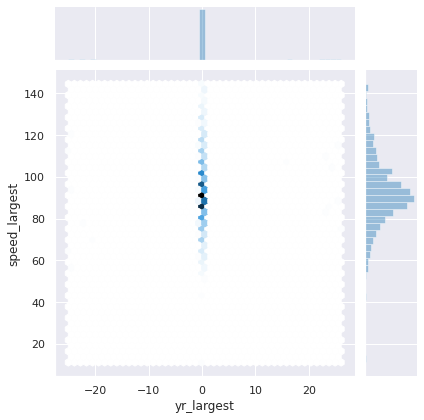

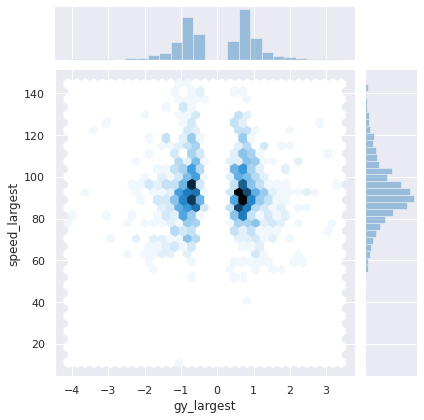

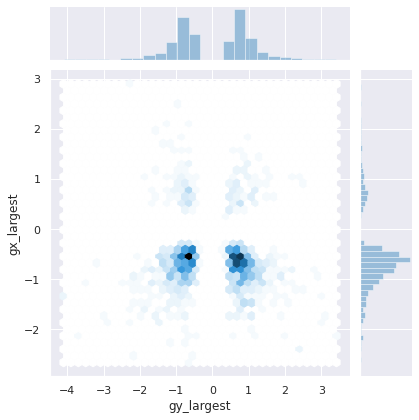

In [9]:
sns.jointplot(x="yr_largest", y="speed_largest", data=corner, kind='hex')
sns.jointplot(x="gy_largest", y="speed_largest", data=corner, kind='hex')
sns.jointplot(x="gy_largest", y="gx_largest", data=corner, kind='hex')

Some straight event statistics

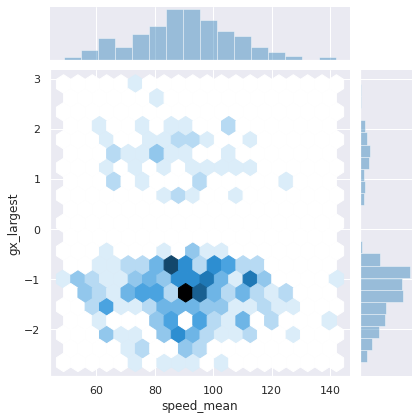

In [10]:
sns.jointplot(x="speed_mean", y="gx_largest", data=straight, kind='hex');

I will compress the data with their change point and trace the average corner event shape in YR

In [11]:
with ProgressBar():
    df_corner_compress = df.map_partitions(
        lambda x: lib.event_detection.change_points_event(x, 'corner_event')
    ).reset_index(drop=True).compute()

display(df_corner_compress.head())

[########################################] | 100% Completed |  5.8s


,timestamp,time_gps,latitude,longitude,altitude,vertical accuracy,horizontal accuracy,course,difcourse: course variation,position state,lanex dist state,lanex history,path,trip_gps,time_osm,current road maxspeed,maxspeed reliability,road type,# of lanes in road,estimated current lane,latitude used to query osm,longitude used to query osm,delay answer osm query,trip_osm,time,above 50kph,gx,gy,gz,gx_filt,gy_filt,gz_filt,roll,pitch,yaw,trip,speed,yr,beta,vx,vy,curvature,distx,disty,distance,change_points,dtime,corner_flag,straight_flag,corner_event,straight_event
0,2015-12-11 16:59:30.210,188.88,40.555028,-3.494186,731.9,4.0,5.0,266.8,4.922,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,-0.008065,0.368134,0.31392,-0.007,0.021,0.038,-1.562915,0.001808,-0.828135,12km-D5-AGGRESSIVE-SECONDARY,91.608581,-0.057682,0.393753,25.446227,0.174876,-25276.554822,2.544946,-0.021615,2.545039,True,0.1,True,True,12km-D5-AGGRESSIVE-SECONDARY24x21,12km-D5-AGGRESSIVE-SECONDARY3x71
1,2015-12-11 16:59:30.510,188.88,40.555010,-3.494273,731.9,4.0,5.0,266.8,4.922,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,-0.688127,0.440066,0.05886,-0.050,0.042,0.006,-1.569131,0.001341,-0.846071,12km-D5-AGGRESSIVE-SECONDARY,91.532428,-0.063831,0.468391,25.424825,0.207852,-22822.638925,2.542858,-0.017399,2.542918,True,0.1,True,True,12km-D5-AGGRESSIVE-SECONDARY24x21,12km-D5-AGGRESSIVE-SECONDARY3x71
2,2015-12-11 16:59:30.910,188.88,40.554986,-3.494389,731.9,4.0,5.0,266.8,4.922,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.182135,0.428029,0.07848,-0.034,0.039,-0.003,-1.574650,-0.014367,-0.876051,12km-D5-AGGRESSIVE-SECONDARY,91.430890,-0.075430,0.461464,25.396646,0.204551,-19291.749390,2.540034,-0.018748,2.540103,True,0.1,True,True,12km-D5-AGGRESSIVE-SECONDARY24x21,12km-D5-AGGRESSIVE-SECONDARY3x71
3,2015-12-11 16:59:31.210,188.88,40.554968,-3.494476,731.9,4.0,5.0,266.8,4.922,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,-1.077560,0.366485,-0.28449,-0.047,0.038,-0.038,-1.581822,-0.014961,-0.897135,12km-D5-AGGRESSIVE-SECONDARY,91.354737,-0.067150,0.396226,25.375709,0.175487,-21652.319401,2.537879,-0.023501,2.537988,True,0.1,True,True,12km-D5-AGGRESSIVE-SECONDARY24x21,12km-D5-AGGRESSIVE-SECONDARY3x71
4,2015-12-11 16:59:31.510,188.88,40.554950,-3.494563,731.9,4.0,5.0,266.8,4.922,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,1.107441,0.143608,-0.05886,-0.023,0.046,-0.009,-1.582030,-0.024528,-0.918217,12km-D5-AGGRESSIVE-SECONDARY,91.278584,-0.075968,0.177226,25.355041,0.078428,-19123.182927,2.535712,-0.027422,2.535866,True,0.1,False,True,12km-D5-AGGRESSIVE-SECONDARY24x21,12km-D5-AGGRESSIVE-SECONDARY3x71


corner_event
12km-D5-AGGRESSIVE-SECONDARY24x21    AxesSubplot(0.125,0.125;0.775x0.755)
12km-D5-AGGRESSIVE-SECONDARY28x41    AxesSubplot(0.125,0.125;0.775x0.755)
12km-D5-AGGRESSIVE-SECONDARY32x21    AxesSubplot(0.125,0.125;0.775x0.755)
12km-D5-AGGRESSIVE-SECONDARY38x91    AxesSubplot(0.125,0.125;0.775x0.755)
12km-D5-AGGRESSIVE-SECONDARY40x31    AxesSubplot(0.125,0.125;0.775x0.755)
                                                     ...                 
26km-D6-NORMAL-MOTORWAY90x97         AxesSubplot(0.125,0.125;0.775x0.755)
26km-D6-NORMAL-MOTORWAY91x07         AxesSubplot(0.125,0.125;0.775x0.755)
26km-D6-NORMAL-MOTORWAY94x97         AxesSubplot(0.125,0.125;0.775x0.755)
26km-D6-NORMAL-MOTORWAY95x77         AxesSubplot(0.125,0.125;0.775x0.755)
26km-D6-NORMAL-MOTORWAY98x97         AxesSubplot(0.125,0.125;0.775x0.755)
Name: gy, Length: 999, dtype: object

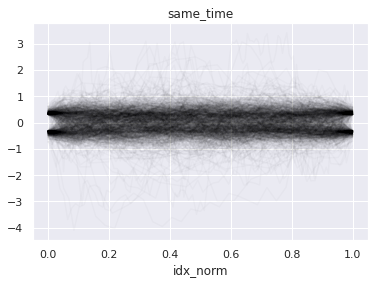

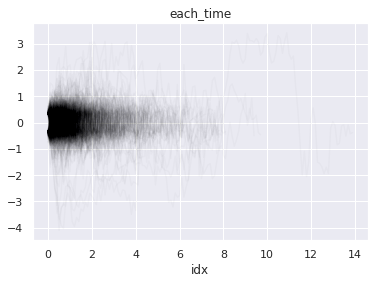

In [12]:
df_corner_plot = df_corner_compress[['gy', 'dtime', 'corner_event']]\
                                    .groupby('corner_event')\
                                    .progress_apply(lib.event_detection.normalize_index, col='dtime')

plt.figure()
df_corner_plot.set_index('idx_norm')\
              .groupby('corner_event')['gy']\
              .plot(alpha=0.02, style='k', title='same_time')

plt.figure()
df_corner_plot.set_index('idx')\
              .groupby('corner_event')['gy']\
              .plot(alpha=0.02, style='k', title='each_time')

corner_event
12km-D5-AGGRESSIVE-SECONDARY24x21    AxesSubplot(0.125,0.125;0.775x0.755)
12km-D5-AGGRESSIVE-SECONDARY28x41    AxesSubplot(0.125,0.125;0.775x0.755)
12km-D5-AGGRESSIVE-SECONDARY32x21    AxesSubplot(0.125,0.125;0.775x0.755)
12km-D5-AGGRESSIVE-SECONDARY38x91    AxesSubplot(0.125,0.125;0.775x0.755)
12km-D5-AGGRESSIVE-SECONDARY40x31    AxesSubplot(0.125,0.125;0.775x0.755)
                                                     ...                 
26km-D6-NORMAL-MOTORWAY90x97         AxesSubplot(0.125,0.125;0.775x0.755)
26km-D6-NORMAL-MOTORWAY91x07         AxesSubplot(0.125,0.125;0.775x0.755)
26km-D6-NORMAL-MOTORWAY94x97         AxesSubplot(0.125,0.125;0.775x0.755)
26km-D6-NORMAL-MOTORWAY95x77         AxesSubplot(0.125,0.125;0.775x0.755)
26km-D6-NORMAL-MOTORWAY98x97         AxesSubplot(0.125,0.125;0.775x0.755)
Name: gy, Length: 999, dtype: object

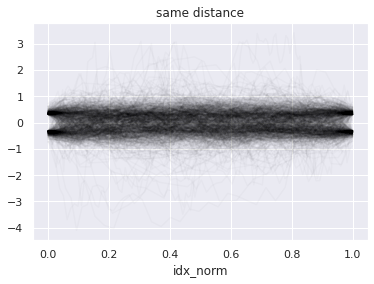

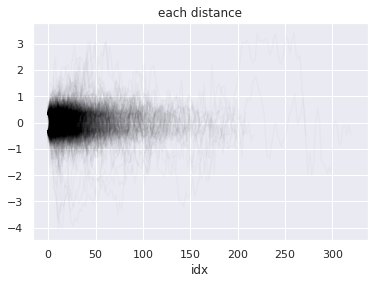

In [13]:
df_corner_plot = df_corner_compress[['gy', 'distance', 'corner_event']]\
                                    .groupby('corner_event')\
                                    .progress_apply(lib.event_detection.normalize_index, col='distance')

plt.figure()
df_corner_plot.set_index('idx_norm')\
              .groupby('corner_event')['gy']\
              .plot(alpha=0.02, style='k', title='same distance')

plt.figure()
df_corner_plot.set_index('idx')\
              .groupby('corner_event')['gy']\
              .plot(alpha=0.02, style='k', title='each distance')

## Application

Let's select some data for the GAN study now

In [14]:
df = lib.util.read_parquet_and_prepare(
    filepath=Path(folderpath, 'data_event.parquet'),
    col_reindex=None
)

In [15]:
df = df.categorize(columns=['corner_event', 'straight_event'])

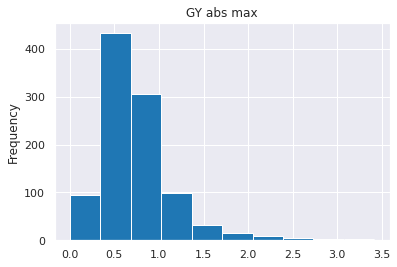

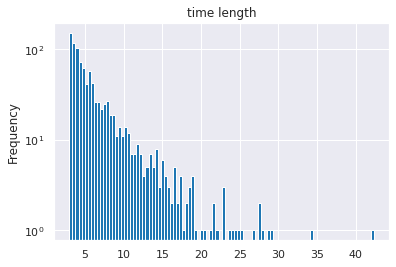

In [16]:
absmax = lib.util.dask_agg_absmax()

corner_feature = df.groupby('corner_event')\
                   .agg({'dtime':'sum','gy':absmax})\
                   .compute()
plt.figure()
corner_feature['gy'].plot(kind='hist', title='GY abs max');
plt.figure()
corner_feature['dtime'].plot(kind='hist', title='time length', logy=True, bins=100);

So from previous 2D plots and the lineplot of all corner event, I select those with more movement and which their length/duration is not an outlier.

'159 / 999 events selected'

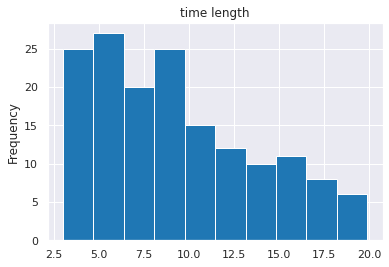

In [17]:
corner_select = (corner_feature['gy'] > 1) & (corner_feature['dtime'] < 20)
display(f'{corner_select.sum()} / {corner_select.shape[0]} events selected')
corner_feature[corner_select]['dtime'].plot(kind='hist', title='time length');

To avoid issues, I converted categorical data into known categorical (with static categories) with "df.categorize"  
see [Dask Categorical](https://docs.dask.org/en/latest/dataframe-categoricals.html)

In [18]:
rem_cat = corner_select.index[~corner_select]

df['corner_select'] = df['corner_event'].cat.remove_categories(rem_cat)

In [19]:
df.head()

,timestamp,time_gps,latitude,longitude,altitude,vertical accuracy,horizontal accuracy,course,difcourse: course variation,position state,lanex dist state,lanex history,path,trip_gps,time_osm,current road maxspeed,maxspeed reliability,road type,# of lanes in road,estimated current lane,latitude used to query osm,longitude used to query osm,delay answer osm query,trip_osm,time,above 50kph,gx,gy,gz,gx_filt,gy_filt,gz_filt,roll,pitch,yaw,trip,speed,yr,beta,vx,vy,curvature,distx,disty,distance,change_points,dtime,corner_flag,straight_flag,corner_event,straight_event,corner_select
idx,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2015-12-11 16:56:19.910,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.107936,-0.041451,-0.39240,-0.006,-0.009,-0.022,-1.561743,0.011128,0.097137,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.004842,-0.044547,36.632824,-0.028482,433436.793932,0.000000,0.000000,0.000000,False,0.0,False,True,NaN,NaN,NaN
1,2015-12-11 16:56:20.010,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.186017,-0.053898,-0.36297,-0.002,-0.006,-0.034,-1.561573,0.013535,0.097621,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.005547,-0.057444,36.632817,-0.036728,378370.393667,3.663279,0.002966,3.663280,False,0.1,False,True,NaN,NaN,NaN
2,2015-12-11 16:56:20.110,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.213286,-0.044389,-0.12753,0.011,-0.010,-0.021,-1.560896,0.015397,0.098246,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.006464,-0.048522,36.632822,-0.031023,324710.369281,3.663279,0.002874,3.663280,False,0.1,False,True,NaN,NaN,NaN
3,2015-12-11 16:56:20.210,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.229753,0.008214,-0.40221,0.023,-0.002,-0.031,-1.559989,0.016346,0.098914,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.008321,0.002894,36.632835,0.001850,252239.921285,3.663285,0.004844,3.663289,False,0.1,False,True,NaN,NaN,NaN
4,2015-12-11 16:56:20.310,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.132273,-0.010419,-0.40221,0.023,-0.002,-0.031,-1.557711,0.017944,0.099910,12km-D5-AGGRESSIVE-SECONDARY,131.878207,0.009965,-0.016791,36.632834,-0.010735,210630.254921,3.663275,0.005912,3.663280,False,0.1,False,True,NaN,NaN,NaN


## Compression for each corner event selected

In [20]:
def get_compression(df):

    compression = lib.data_preparation.calculate_change_point(
        df=df.dropna(subset=['corner_select']),
        groupby='corner_select',
        col=['gy', 'gx']
    )
    df = df.join(compression.rename('compression'))
    df['compression'] = df['compression'].fillna(False)

    return df


with ProgressBar():
    df = df.map_partitions(
        get_compression,
        meta=get_compression(df.head())
    ).compute()

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  7.8s


In [21]:
df = df.dropna(subset=['corner_select'])
df = df.reset_index(drop=True)
df = df.sort_values(['corner_select', 'timestamp'])

In [22]:
df = df\
    .groupby('corner_select')\
    .progress_apply(lambda x: x.assign(
        time_event=lambda df: df['dtime'].cumsum() - df['dtime'].iloc[0],
        time_event_norm=lambda df: df['time_event'] / df['time_event'].iloc[-1],
        dist_event=lambda df: df['distance'].cumsum() - df['distance'].iloc[0],
        dist_event_norm=lambda df: df['dist_event'] / df['dist_event'].iloc[-1]
    ))

In [23]:
display(df.head())
display(f"{df['corner_select'].unique().shape[0]} events")
display(f"compression: {df['compression'].sum()/df['compression'].shape[0]}%")
display(f'{df.memory_usage(deep=True).sum()/10**6}MB of memory')

,timestamp,time_gps,latitude,longitude,altitude,vertical accuracy,horizontal accuracy,course,difcourse: course variation,position state,lanex dist state,lanex history,path,trip_gps,time_osm,current road maxspeed,maxspeed reliability,road type,# of lanes in road,estimated current lane,latitude used to query osm,longitude used to query osm,delay answer osm query,trip_osm,time,above 50kph,gx,gy,gz,gx_filt,gy_filt,gz_filt,roll,pitch,yaw,trip,speed,yr,beta,vx,vy,curvature,distx,disty,distance,change_points,dtime,corner_flag,straight_flag,corner_event,straight_event,corner_select,compression,time_event,time_event_norm,dist_event,dist_event_norm
173,2015-12-11 16:59:45.410,217.86,40.554350,-3.498596,738.5,4.0,5.0,277.0,3.867,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,-0.429423,-0.319247,-0.32373,-0.027,-0.006,-0.034,-1.576240,-0.074800,-1.645088,12km-D5-AGGRESSIVE-SECONDARY,89.878333,-0.036633,-0.303285,24.965854,-0.132154,-39048.842688,2.494532,-0.080582,2.495837,True,0.1,True,True,12km-D5-AGGRESSIVE-SECONDARY28x41,12km-D5-AGGRESSIVE-SECONDARY3x71,12km-D5-AGGRESSIVE-SECONDARY28x41,False,0.0,0.000000,0.000000,0.000000
174,2015-12-11 16:59:45.510,217.86,40.554355,-3.498625,738.5,4.0,5.0,277.0,3.867,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,-0.139842,-0.309281,-0.53955,-0.048,-0.029,-0.043,-1.574005,-0.073217,-1.648911,12km-D5-AGGRESSIVE-SECONDARY,89.935000,-0.036860,-0.293210,24.981617,-0.127844,-38831.938844,2.495966,-0.084773,2.497405,False,0.1,True,True,12km-D5-AGGRESSIVE-SECONDARY28x41,12km-D5-AGGRESSIVE-SECONDARY3x71,12km-D5-AGGRESSIVE-SECONDARY28x41,False,0.1,0.006135,2.497405,0.006049
175,2015-12-11 16:59:45.610,217.86,40.554359,-3.498655,738.5,4.0,5.0,277.0,3.867,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.105614,-0.167763,-0.08829,-0.011,-0.029,-0.031,-1.569440,-0.073993,-1.652460,12km-D5-AGGRESSIVE-SECONDARY,89.991667,-0.033204,-0.153276,24.997596,-0.066873,-43134.589195,2.497641,-0.081717,2.498979,True,0.1,False,True,12km-D5-AGGRESSIVE-SECONDARY28x41,12km-D5-AGGRESSIVE-SECONDARY3x71,12km-D5-AGGRESSIVE-SECONDARY28x41,True,0.2,0.012270,4.996384,0.012102
176,2015-12-11 16:59:45.710,217.86,40.554363,-3.498684,738.5,4.0,5.0,277.0,3.867,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,-0.045568,-0.078230,-0.36297,0.004,-0.019,-0.024,-1.563134,-0.075886,-1.655552,12km-D5-AGGRESSIVE-SECONDARY,90.048333,-0.030044,-0.065113,25.013410,-0.028426,-47702.127756,2.499375,-0.076939,2.500559,False,0.1,False,True,12km-D5-AGGRESSIVE-SECONDARY28x41,12km-D5-AGGRESSIVE-SECONDARY3x71,12km-D5-AGGRESSIVE-SECONDARY28x41,False,0.3,0.018405,7.496943,0.018159
177,2015-12-11 16:59:45.810,217.86,40.554367,-3.498713,738.5,4.0,5.0,277.0,3.867,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,-0.207676,-0.067517,-0.59841,-0.006,-0.009,-0.045,-1.557720,-0.077434,-1.658469,12km-D5-AGGRESSIVE-SECONDARY,90.105000,-0.029180,-0.054771,25.029155,-0.023926,-49145.961989,2.501004,-0.074969,2.502127,False,0.1,False,True,12km-D5-AGGRESSIVE-SECONDARY28x41,12km-D5-AGGRESSIVE-SECONDARY3x71,12km-D5-AGGRESSIVE-SECONDARY28x41,False,0.4,0.024540,9.999071,0.024220


'159 events'

'compression: 0.28091025727598085%'

'10.408472MB of memory'

## Quick Sanity plots

Text(0.5, 1.0, 'compression per event')

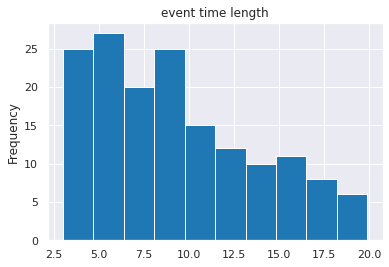

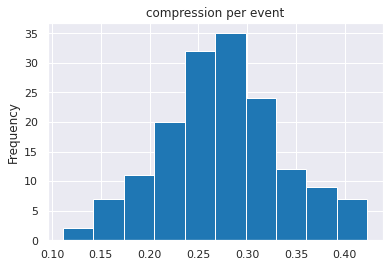

In [24]:
plt.figure()
corner_select_time = df.groupby('corner_select')['dtime'].sum()
corner_select_time.plot(kind='hist')
plt.title('event time length')

plt.figure()
corner_select_time = df.groupby('corner_select')['compression'].agg(lambda x: x.sum() / x.shape[0])
corner_select_time.plot(kind='hist')
plt.title('compression per event')

In [25]:
df_analysis = df.groupby('corner_select')\
                [['gx', 'gy']]\
                .agg(['max', 'min'])\
                .stack()

display(df_analysis.head())

gx        gy
corner_select                                            
12km-D5-AGGRESSIVE-SECONDARY28x41 max  0.803261  2.235359
                                  min -1.246269 -1.001068
12km-D5-AGGRESSIVE-SECONDARY56x01 max  0.595551  1.436864
                                  min -0.549961 -1.538498
12km-D5-AGGRESSIVE-SECONDARY6x91  max  0.789258  1.895936

'min & max for GX/GY in each event'

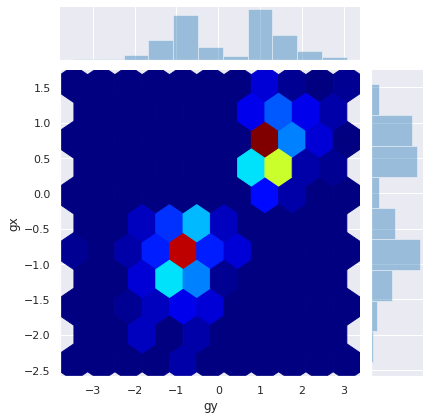

In [26]:
display('min & max for GX/GY in each event')
sns.jointplot('gy', 'gx', df_analysis, kind='hex', cmap='jet')

In [27]:
def absmax(x):
    return abs(max(x))
def extent(x):
    return x.max() - x.min()

df_analysis_speed = df.groupby('corner_select').agg({
    'gy':[absmax, extent],
    'speed':'max'
})
df_analysis_speed.columns = df_analysis_speed.columns.to_flat_index()
df_analysis_speed = df_analysis_speed.rename(columns=lambda x: '_'.join(x))

display(df_analysis_speed.head(1))

,gy_absmax,gy_extent,speed_max
corner_select,,,
12km-D5-AGGRESSIVE-SECONDARY28x41,2.235359,3.236427,91.835588


'speed and 2 values of GY, its extent or its absolute max'

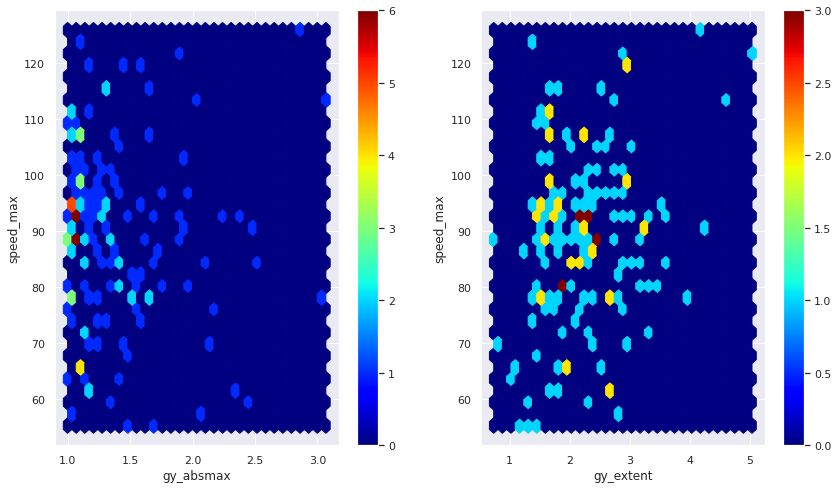

In [28]:
display('speed and 2 values of GY, its extent or its absolute max')

_, axes = plt.subplots(1,2, figsize=(14, 8))
for k, x in enumerate(['gy_absmax', 'gy_extent']):
    df_analysis_speed.plot.hexbin(x=x, y='speed_max', cmap='jet', gridsize=30, ax=axes[k])

The 2D histogram have been encapsulated under:
 - "lib.analysis.plot_gx_gy()"
 - "lib.analysis.plot_gy_speed()"

corner_select
12km-D5-AGGRESSIVE-SECONDARY28x41    AxesSubplot(0.125,0.125;0.775x0.755)
12km-D5-AGGRESSIVE-SECONDARY56x01    AxesSubplot(0.125,0.125;0.775x0.755)
12km-D5-AGGRESSIVE-SECONDARY6x91     AxesSubplot(0.125,0.125;0.775x0.755)
13km-D1-DROWSY-SECONDARY2x14         AxesSubplot(0.125,0.125;0.775x0.755)
13km-D1-DROWSY-SECONDARY61x24        AxesSubplot(0.125,0.125;0.775x0.755)
                                                     ...                 
26km-D6-NORMAL-MOTORWAY4x47          AxesSubplot(0.125,0.125;0.775x0.755)
26km-D6-NORMAL-MOTORWAY70x07         AxesSubplot(0.125,0.125;0.775x0.755)
26km-D6-NORMAL-MOTORWAY88x87         AxesSubplot(0.125,0.125;0.775x0.755)
26km-D6-NORMAL-MOTORWAY91x07         AxesSubplot(0.125,0.125;0.775x0.755)
26km-D6-NORMAL-MOTORWAY98x97         AxesSubplot(0.125,0.125;0.775x0.755)
Name: gy, Length: 159, dtype: object

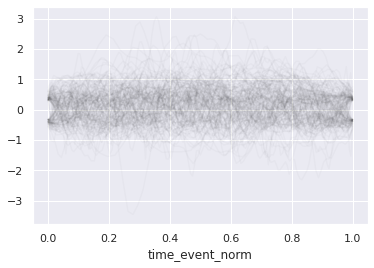

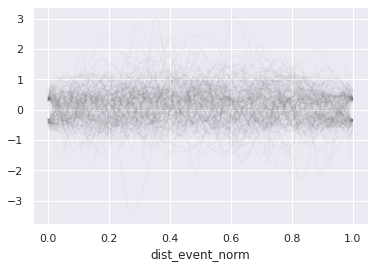

In [29]:
plt.figure()
df.set_index('time_event_norm')\
  .groupby('corner_select')['gy']\
  .plot(style='k', alpha=0.02)

plt.figure()
df.set_index('dist_event_norm')\
  .groupby('corner_select')['gy']\
  .plot(style='k', alpha=0.02)

In [30]:
df = df.groupby('corner_select')\
       .progress_apply(
           lambda x: lib.data_preparation.add_vd_signal(x, x['time_event'], method='integral')
        )
display(df.head())

,timestamp,time_gps,latitude,longitude,altitude,vertical accuracy,horizontal accuracy,course,difcourse: course variation,position state,lanex dist state,lanex history,path,trip_gps,time_osm,current road maxspeed,maxspeed reliability,road type,# of lanes in road,estimated current lane,latitude used to query osm,longitude used to query osm,delay answer osm query,trip_osm,time,above 50kph,gx,gy,gz,gx_filt,gy_filt,gz_filt,roll,pitch,yaw,trip,speed,yr,beta,vx,vy,curvature,distx,disty,distance,change_points,dtime,corner_flag,straight_flag,corner_event,straight_event,corner_select,compression,time_event,time_event_norm,dist_event,dist_event_norm
173,2015-12-11 16:59:45.410,217.86,40.554350,-3.498596,738.5,4.0,5.0,277.0,3.867,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,-4.212635,-3.131816,-3.175791,-0.027,-0.006,-0.034,-1.576240,-0.074800,-1.645088,12km-D5-AGGRESSIVE-SECONDARY,89.878333,-0.038236,-3.115155,24.929312,-1.356737,-37410.938686,0.000000,0.000000,0.000000,True,0.1,True,True,12km-D5-AGGRESSIVE-SECONDARY28x41,12km-D5-AGGRESSIVE-SECONDARY3x71,12km-D5-AGGRESSIVE-SECONDARY28x41,False,0.0,0.000000,0.000000,0.000000
174,2015-12-11 16:59:45.510,217.86,40.554355,-3.498625,738.5,4.0,5.0,277.0,3.867,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,-1.371846,-3.034051,-5.292986,-0.048,-0.029,-0.043,-1.574005,-0.073217,-1.648911,12km-D5-AGGRESSIVE-SECONDARY,89.935000,-0.036860,-3.017979,24.947296,-1.315282,-38831.938844,2.488958,-0.205222,2.497405,False,0.1,True,True,12km-D5-AGGRESSIVE-SECONDARY28x41,12km-D5-AGGRESSIVE-SECONDARY3x71,12km-D5-AGGRESSIVE-SECONDARY28x41,False,0.1,0.006135,2.497405,0.006049
175,2015-12-11 16:59:45.610,217.86,40.554359,-3.498655,738.5,4.0,5.0,277.0,3.867,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,1.036075,-1.645751,-0.866125,-0.011,-0.029,-0.031,-1.569440,-0.073993,-1.652460,12km-D5-AGGRESSIVE-SECONDARY,89.991667,-0.033204,-1.631265,24.987554,-0.711611,-43134.589195,4.981744,-0.378446,4.996384,True,0.1,False,True,12km-D5-AGGRESSIVE-SECONDARY28x41,12km-D5-AGGRESSIVE-SECONDARY3x71,12km-D5-AGGRESSIVE-SECONDARY28x41,True,0.2,0.012270,4.996384,0.012102
176,2015-12-11 16:59:45.710,217.86,40.554363,-3.498684,738.5,4.0,5.0,277.0,3.867,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,-0.447022,-0.767433,-3.560736,0.004,-0.019,-0.024,-1.563134,-0.075886,-1.655552,12km-D5-AGGRESSIVE-SECONDARY,90.048333,-0.030044,-0.754317,25.011258,-0.329300,-47702.127756,7.479144,-0.502628,7.496943,False,0.1,False,True,12km-D5-AGGRESSIVE-SECONDARY28x41,12km-D5-AGGRESSIVE-SECONDARY3x71,12km-D5-AGGRESSIVE-SECONDARY28x41,False,0.3,0.018405,7.496943,0.018159
177,2015-12-11 16:59:45.810,217.86,40.554367,-3.498713,738.5,4.0,5.0,277.0,3.867,0.0,5.0,1.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,146.07,90.0,1.0,primary,2.0,1.0,40.552727,-3.478715,1.222,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,-2.037298,-0.662346,-5.870402,-0.006,-0.009,-0.045,-1.557720,-0.077434,-1.658469,12km-D5-AGGRESSIVE-SECONDARY,90.105000,-0.029180,-0.649600,25.027558,-0.283766,-49145.961989,9.979150,-0.605615,9.999071,False,0.1,False,True,12km-D5-AGGRESSIVE-SECONDARY28x41,12km-D5-AGGRESSIVE-SECONDARY3x71,12km-D5-AGGRESSIVE-SECONDARY28x41,False,0.4,0.024540,9.999071,0.024220


## Example of trajectory plot

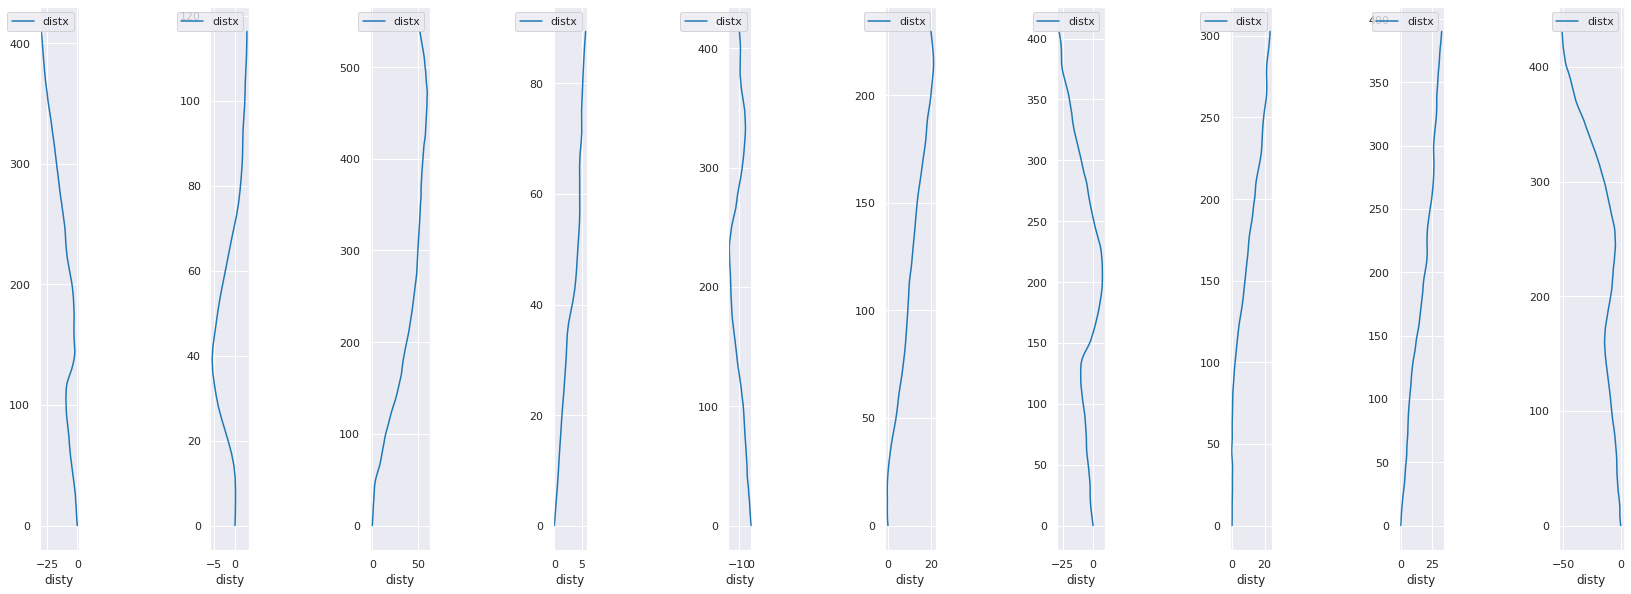

In [33]:
n_example = 10

group_select = df['corner_select'].unique()

fig, axes = plt.subplots(ncols=n_example, figsize=(30, 10))

for k, group in enumerate(group_select[:n_example]):
    df.query(f'corner_select=="{group}"')\
    [['distx', 'disty']]\
    .plot(x='disty', y='distx', ax=axes[k])
    axes[k].set_aspect('equal')

In [32]:
df.to_parquet(Path(folderpath, 'data_ready.parquet'))